**Набор данных MNIST**

In [ ]:
#1) Загрузка библиотек:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [ ]:
#2) Разбитие наборов на обучающий и тестовый датасета "MNIST":
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#3) Проверка числа объектов в выборках:
print(trainloader.dataset.train_data.shape)
print(testloader.dataset.test_data.shape)


torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


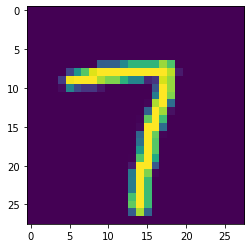

In [ ]:
#4) Преобразование тензора в numpy:
i = np.random.randint(low=0, high=60000)
numpy_img = trainloader.dataset.train_data[i].numpy()
plt.imshow(numpy_img)

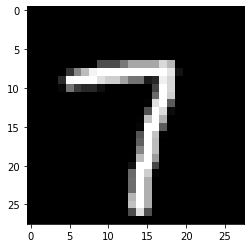

In [ ]:
#6) Удаление цветов в полученной картинке:
plt.imshow(numpy_img, cmap='gray')

In [ ]:
#7) Формирование  для нейронной сети:
class SimpleConvNet(nn.Module):
    def __init__(self, args):
        self.c1, self.c2, self.f1, self.f2 = args
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.c1, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=self.c1, out_channels=self.c2, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * self.c2, self.f1)  
        self.fc2 = nn.Linear(self.f1, self.f2)
        self.fc3 = nn.Linear(self.f2, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, 4 * 4 * self.c2)  
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

print('Число выходных нейронов было увелечино до 64 на первой конволюции и до 128 на второй конволюции, а также функции активации на слоях неронной сети были изменены на "leaky_relu', '\n', 'в силу большей гибкости результатов, кроме последнего слоя, на котором была поставлена "softmax" с целью нормализации результатов количество эпох для обучения будет оставлено', '\n', 'на 3 по причине больших временных затрат.')

Число выходных нейронов было увелечино до 64 на первой конволюции и до 128 на второй конволюции, а также функции активации на слоях неронной сети были изменены на "leaky_relu 
 в силу большей гибкости результатов, кроме последнего слоя, на котором была поставлена "softmax" с целью нормализации результатов количество эпох для обучения будет оставлено 
 на 3 по причине больших временных затрат.


In [ ]:
#8) Обучение нейронной сети:
net = SimpleConvNet([64, 128, 128, 64])
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in tqdm(range(3)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
#4) Проверка работы нейронной сети на тестовом датасете:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

tt = []
pp = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        
        _, predicted = torch.max(y_pred, 1)
        tt.extend(labels)
        pp.extend(predicted)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %4.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of     0 : 98.67 %
Accuracy of     1 : 97.97 %
Accuracy of     2 : 98.16 %
Accuracy of     3 : 99.41 %
Accuracy of     4 : 97.76 %
Accuracy of     5 : 97.87 %
Accuracy of     6 : 97.91 %
Accuracy of     7 : 98.74 %
Accuracy of     8 : 96.41 %
Accuracy of     9 : 97.92 %


Результаты работы сети улучшились и стали практически идеальными за исключением цифры "9", которая может быть воспринята за другие цифры в силу специфики её написания.


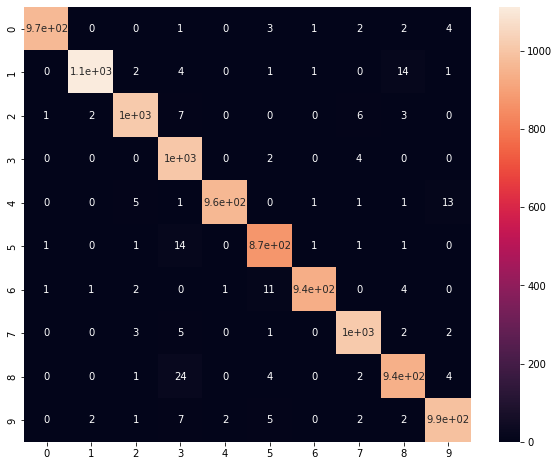

In [ ]:
#5) Матрица соответствий:
print('Результаты работы сети улучшились и стали практически идеальными за исключением цифры "9", которая может быть воспринята за другие цифры в силу специфики её написания.')
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(confusion_matrix(tt, pp)), annot=True)

In [ ]:
#6)  Формирование сисетмы определения:
def predict_on_test_example(idx):

    img, label = testset[idx]
    plt.imshow(img.squeeze().numpy())
    y_pred = net(img.unsqueeze(dim=0))
    _, predicted = torch.max(y_pred, 1)
    print(f'Модель предсказала класс: {predicted.item()}') 

Модель предсказала класс: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


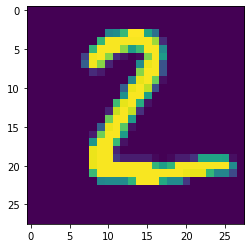

In [ ]:
#7) Cистема определения:
predict_on_test_example(1);

**Набор данных CIFAR10**

In [ ]:
#8) Создание обучающей и тестовой выборок на основе датасета "CIFAR10"
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='D:/nvb/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='D:/nvb//data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting D:/nvb/data/cifar-10-python.tar.gz to D:/nvb/data
Files already downloaded and verified


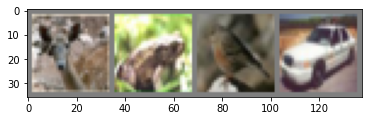

In [ ]:
#9) Демонстрация случайных изображений:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
#10) Формирвоание нейронной сети:
class MyConvNet(nn.Module):
    def __init__(self, args):
        self.c1, self.c2, self.f1, self.f2 = args
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.c1, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=self.c1, out_channels=self.c2, kernel_size=5)
        self.fc1 = nn.Linear(self.c2 * 765, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, self.c2 * 765) 
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x
print('Число выходных нейронов было увелечино до 12 на первой конволюции и до 32 на второй конволюции, а также функции активации на слоях неронной сети были изменены на "leaky_relu', '\n', 'в силу большей гибкости результатов, кроме последнего слоя, на котором была поставлена "softmax" с целью нормализации результатов количество эпох для обучения будет оставлено', '\n', 'на 5 по причине больших временных затрат.')

Число выходных нейронов было увелечино до 12 на первой конволюции и до 32 на второй конволюции, а также функции активации на слоях неронной сети были изменены на "leaky_relu 
 в силу большей гибкости результатов, кроме последнего слоя, на котором была поставлена "softmax" с целью нормализации результатов количество эпох для обучения будет оставлено 
 на 5 по причине больших временных затрат.


In [ ]:
#11) Обучение нейронной сети:
net = MyConvNet([12, 32, 32, 12])

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        X_batch, y_batch = batch
        X_batch = X_batch.view(4, -1)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 2.170
[1,  4000] loss: 2.097
[1,  6000] loss: 2.068
[1,  8000] loss: 2.052
[1, 10000] loss: 2.040
[1, 12000] loss: 2.025


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.996
[2,  4000] loss: 1.989
[2,  6000] loss: 1.983
[2,  8000] loss: 1.977
[2, 10000] loss: 1.975
[2, 12000] loss: 1.962


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.936
[3,  4000] loss: 1.935
[3,  6000] loss: 1.924
[3,  8000] loss: 1.933
[3, 10000] loss: 1.922
[3, 12000] loss: 1.925


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.895
[4,  4000] loss: 1.891
[4,  6000] loss: 1.894
[4,  8000] loss: 1.884
[4, 10000] loss: 1.882
[4, 12000] loss: 1.887


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 1.851
[5,  4000] loss: 1.859
[5,  6000] loss: 1.858
[5,  8000] loss: 1.861
[5, 10000] loss: 1.858
[5, 12000] loss: 1.858
Обучение закончено


In [ ]:
#12) Применение обученной нейронной сети на тестовой выборке:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

tt = []
pp = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        tt.extend(labels)
        pp.extend(predicted)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %4.2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of plane : 64.00 %
Accuracy of   car : 65.70 %
Accuracy of  bird : 53.60 %
Accuracy of   cat : 34.80 %
Accuracy of  deer : 43.60 %
Accuracy of   dog : 44.20 %
Accuracy of  frog : 62.60 %
Accuracy of horse : 60.20 %
Accuracy of  ship : 76.60 %
Accuracy of truck : 64.10 %


In [ ]:
#13) Проверка точности сформированной нейронной сети:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
print('Доля верно угаданных категорий:', mean_accuracy)
print('Доля незначительно увеличилась')

Доля верно угаданных категорий: 0.5694
Доля незначительно увеличилась
